<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/dacon_timeseries/blob/main/final_model/%EC%8B%9C%EA%B3%84%EC%97%B4_1%ED%8C%80_0612_private_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

적설, 강수 등 빼고 학습시킴

* 이미지 한 장이 하루여야 함
* 72시간의 데이터를 갖고 73번째 시간대의 데이터를 예측하는것

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from google.colab import drive
from datetime import datetime, timedelta

import math
import time
import random

import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.externals import joblib

drive.mount('./gdrive', force_remount=True)
plt.style.use("fivethirtyeight")
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at ./gdrive


In [ ]:
dangjin_fcst = pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/new_dangjin_fcst.csv")
ulsan_fcst = pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/new_ulsan_fcst.csv")
energy = pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/new_energy.csv")

In [ ]:
#일조, 일사 데이터 여기서 불러와서 concat하기
'''
chch_sun=pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/prep_chch_sun.csv")
ulsan_sun=pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/prep_ulsan_sun.csv")
chch_sun.rename(columns={'일시':'Forecast_time','일조(hr)':'일조','일사(MJ/m2)':'일사'}, inplace=True)
ulsan_sun.rename(columns={'일시':'Forecast_time','일조(hr)':'일조','일사(MJ/m2)':'일사'}, inplace=True)
'''

In [ ]:
dangjin_fcst

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위
0,2016-12-02 00:00:00,0.4,0.0,0.0,67.0,8.6,356.0,1.0,NaN,NaN,340 03 04.02,-74 04 10.40,16 32 56.04,-21 55 49.38
1,2016-12-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,030 19 39.37,-72 55 00.56,16 33 06.98,-21 56 11.79
2,2016-12-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060 54 26.99,-64 12 35.47,16 33 17.92,-21 56 34.29
3,2016-12-02 03:00:00,-0.7,0.0,0.0,76.0,2.7,341.0,1.0,NaN,NaN,077 02 49.13,-53 01 39.40,16 33 28.84,-21 56 56.88
4,2016-12-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,087 49 23.81,-41 10 38.68,16 33 39.74,-21 57 19.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,2021-02-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274 36 31.31,-19 28 58.57,22 43 34.22,-8 04 37.23
37197,2021-02-28 21:00:00,7.0,0.0,30.0,70.0,1.3,18.0,4.0,NaN,NaN,284 38 48.32,-31 16 00.31,22 43 43.68,-8 03 40.40
37198,2021-02-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296 55 39.10,-42 26 50.80,22 43 53.17,-8 02 43.58
37199,2021-02-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313 32 08.08,-52 14 15.85,22 44 02.67,-8 01 46.80


In [ ]:
energy['time'] = pd.to_datetime(dangjin_fcst['Forecast_time'][:len(energy)])
energy['year'] = energy['time'].dt.year
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy['hour'] = energy['time'].dt.hour
energy['year-month-day'] = energy['year'].astype(str) + "-" + energy['month'].astype(str) + "-" + energy['day'].astype(str)

In [ ]:
date = dangjin_fcst['Forecast_time']

In [ ]:
dangjin_fcst['Temperature'] = dangjin_fcst['Temperature'].interpolate()  #interpolate() 구간 따로 안정하고 column 단위로 통째로 적용하면 되는거 맞음
dangjin_fcst['PrecipitationForm'] = dangjin_fcst['PrecipitationForm'].interpolate()
dangjin_fcst['PrecipitationProb'] = dangjin_fcst['PrecipitationProb'].interpolate()
dangjin_fcst['Humidity'] = dangjin_fcst['Humidity'].interpolate()
dangjin_fcst['WindSpeed'] = dangjin_fcst['WindSpeed'].interpolate()
dangjin_fcst['Cloud'] = dangjin_fcst['Cloud'].interpolate()
dangjin_fcst['Precipitation'] = dangjin_fcst['Precipitation'].interpolate()
dangjin_fcst['Snow'] = dangjin_fcst['Snow'].interpolate()
#dangjin_fcst['WindDirection'] = dangjin_fcst['WindDirection'].interpolate() => 방향으로 바꾸는 작업 해주려고

ulsan_fcst['Temperature'] = ulsan_fcst['Temperature'].interpolate()
ulsan_fcst['PrecipitationForm'] = ulsan_fcst['PrecipitationForm'].interpolate()
ulsan_fcst['PrecipitationProb'] = ulsan_fcst['PrecipitationProb'].interpolate()
ulsan_fcst['Humidity'] = ulsan_fcst['Humidity'].interpolate()
ulsan_fcst['WindSpeed'] = ulsan_fcst['WindSpeed'].interpolate()
ulsan_fcst['Cloud'] = ulsan_fcst['Cloud'].interpolate()
ulsan_fcst['Precipitation'] = ulsan_fcst['Precipitation'].interpolate()
ulsan_fcst['Snow'] = ulsan_fcst['Snow'].interpolate()
#ulsan_fcst['WindDirection'] = ulsan_fcst['WindDirection'].interpolate() 선형보간 안해서 nan 많음

In [ ]:
#Wind Direction 항목 angle에서 방향표시로 바꿔주기
def angle_to_dir(x):
    if pd.isnull(x):
        return np.nan
    elif x >= 22.5 and x <67.5:
        return 'NE'
    elif x >= 67.5 and x < 112.5:
        return 'E'
    elif x >= 112.5 and x < 157.5:
        return 'SE'
    elif x >= 157.5 and x < 202.5:
        return 'S'
    elif x >= 202.5 and x < 247.5:
        return 'WS'
    elif x >= 247.5 and x < 292.5:
        return 'W'
    elif x >= 292.5 and x < 337.5:
        return 'NW'
    elif x >= 337.5 or x < 22.5:
        return 'N'

def angle_to_cos(x):
    return np.cos(np.pi/180*(x-90))
def angle_to_sin(x):
    return np.sin(np.pi/180*(x+90))

dangjin_fcst['WindDirection_x'] = dangjin_fcst['WindDirection'].apply(angle_to_cos)  #Q. 어차피 다 나눠놨는데싸인 코싸인은 왜 씌우는것..?
dangjin_fcst['WindDirection_y'] = dangjin_fcst['WindDirection'].apply(angle_to_sin)
dangjin_fcst['Wind_x'] = dangjin_fcst['WindDirection_x'] * dangjin_fcst['WindSpeed']
dangjin_fcst['Wind_y'] = dangjin_fcst['WindDirection_y'] * dangjin_fcst['WindSpeed']

ulsan_fcst['WindDirection_x'] = ulsan_fcst['WindDirection'].apply(angle_to_cos)
ulsan_fcst['WindDirection_y'] = ulsan_fcst['WindDirection'].apply(angle_to_sin)
ulsan_fcst['Wind_x'] = ulsan_fcst['WindDirection_x'] * ulsan_fcst['WindSpeed']
ulsan_fcst['Wind_y'] = ulsan_fcst['WindDirection_y'] * ulsan_fcst['WindSpeed']


dangjin_fcst['WindDirection'] = dangjin_fcst['WindDirection'].interpolate()
ulsan_fcst['WindDirection'] = ulsan_fcst['WindDirection'].interpolate()

dangjin_fcst['WindDirection_catg'] = dangjin_fcst['WindDirection'].apply(angle_to_dir)
ulsan_fcst['WindDirection_catg'] = ulsan_fcst['WindDirection'].apply(angle_to_dir)

In [ ]:
dangjin_fcst['Wind_x'] = dangjin_fcst['Wind_x'].interpolate()
dangjin_fcst['Wind_y'] = dangjin_fcst['Wind_y'].interpolate()

ulsan_fcst['Wind_x'] = ulsan_fcst['Wind_x'].interpolate()
ulsan_fcst['Wind_y'] = ulsan_fcst['Wind_y'].interpolate()

In [ ]:
'''
dangjin_fcst=pd.merge(dangjin_fcst, chch_sun, how='left', on='Forecast_time')
ulsan_fcst=pd.merge(ulsan_fcst, ulsan_sun, how='left', on='Forecast_time')
'''

"\ndangjin_fcst=pd.merge(dangjin_fcst, chch_sun, how='left', on='Forecast_time')\nulsan_fcst=pd.merge(ulsan_fcst, ulsan_sun, how='left', on='Forecast_time')\n"

In [ ]:

dangjin_fcst['hour'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.hour
dangjin_fcst['day'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.day
dangjin_fcst['month'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.month

ulsan_fcst['hour'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.hour
ulsan_fcst['day'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.day
ulsan_fcst['month'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.month

In [ ]:
#이슬점 직접 계산해서 추가
b = 17.62
c = 243.12
gamma = (b * dangjin_fcst['Temperature'] /(c + dangjin_fcst['Temperature'])) + np.log(dangjin_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
dangjin_fcst['DewPoint'] = dewpoint  

gamma = (b * ulsan_fcst['Temperature'] /(c + ulsan_fcst['Temperature'])) + np.log(ulsan_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
ulsan_fcst['DewPoint'] = dewpoint

In [ ]:
dangjin_fcst['방위각'] = dangjin_fcst['방위각'].apply(lambda x : int(x[:3]))
dangjin_fcst['고도'] = dangjin_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
dangjin_fcst['적경'] = dangjin_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
dangjin_fcst['적위'] = dangjin_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

ulsan_fcst['방위각'] = ulsan_fcst['방위각'].apply(lambda x : int(x[:3]))
ulsan_fcst['고도'] = ulsan_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
ulsan_fcst['적경'] = ulsan_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
ulsan_fcst['적위'] = ulsan_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

In [ ]:
#using_col = ['Temperature', 'DewPoint', 'Humidity', 'Cloud', 'Precipitation', 'Snow' ,'Wind_x', 'Wind_y','hour', 'month', '방위각', '고도', '적경', '적위']
using_col = ['Temperature', 'DewPoint', 'Humidity', 'Cloud', 'Wind_x', 'Wind_y', 'hour', 'month', '방위각', '고도', '적경', '적위']
dangjin_fcst = dangjin_fcst[using_col].fillna(0)
ulsan_fcst = ulsan_fcst[using_col].fillna(0)

In [ ]:
def shift(df, period):
  target = pd.DataFrame()
  for i in range(period, -1, -1): 
    tmp = df.shift(i) 
    target = pd.concat([target, tmp], axis = 1)
  return target

In [ ]:
dangjin_fcst

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위
0,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0,12,340,-74,16.3256,-21.5549
1,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1,12,30,-72,16.3306,-21.5611
2,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2,12,60,-64,16.3317,-21.5634
3,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3,12,77,-53,16.3328,-21.5656
4,-0.933333,-3.950599,80.000000,1.0,-0.761132,2.240865,4,12,87,-41,16.3339,-21.5719
...,...,...,...,...,...,...,...,...,...,...,...,...
37196,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20,2,274,-19,22.4334,-8.0437
37197,7.000000,1.897402,70.000000,4.0,0.401722,1.236373,21,2,284,-31,22.4343,-8.0340
37198,6.666667,1.241159,68.333333,4.0,0.574228,1.130662,22,2,296,-42,22.4353,-8.0243
37199,6.333333,0.579324,66.666667,4.0,0.746733,1.024950,23,2,313,-52,22.4402,-8.0146


In [ ]:
dangjin_fcst = shift(dangjin_fcst, 71)  
ulsan_fcst = shift(ulsan_fcst, 71)                                            

In [ ]:
dangjin_fcst

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,...,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0,12,340,-74,16.3256,-21.5549
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0.0,12.0,340.0,-74.0,16.3256,-21.5549,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1,12,30,-72,16.3306,-21.5611
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0.0,12.0,340.0,-74.0,16.3256,-21.5549,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1.0,12.0,30.0,-72.0,16.3306,-21.5611,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2,12,60,-64,16.3317,-21.5634
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,340.0,-74.0,16.3256,-21.5549,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1.0,12.0,30.0,-72.0,16.3306,-21.5611,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2.0,12.0,60.0,-64.0,16.3317,-21.5634,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3,12,77,-53,16.3328,-21.5656
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,-72.0,16.3306,-21.5611,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2.0,12.0,60.0,-64.0,16.3317,-21.5634,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3.0,12.0,77.0,-53.0,16.3328,-21.5656,-0.933333,-3.950599,80.000000,1.0,-0.761132,2.240865,4,12,87,-41,16.3339,-21.5719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,3.000000,-0.115438,80.000000,4.0,0.414110,1.545481,21.0,2.0,283.0,-31.0,22.3224,-9.1106,2.333333,-1.347498,76.666667,3.0,0.684631,1.373141,22.0,2.0,295.0,-43.0,22.3233,-9.1010,1.666667,-2.596163,73.333333,2.0,0.955151,1.200801,23.0,2.0,312.0,-53.0,22.3243,-9.0914,1.000000,-3.863107,70.000000,1.0,...,246.0,15.0,22.4306,-8.0727,9.000000,1.641382,60.000000,4.0,-0.312585,0.736404,18.0,2.0,256.0,4.0,22.4315,-8.0630,8.333333,1.767587,63.333333,4.0,-0.074483,0.903060,19.0,2.0,265.0,-7.0,22.4324,-8.0534,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20,2,274,-19,22.4334,-8.0437
37197,2.333333,-1.347498,76.666667,3.0,0.684631,1.373141,22.0,2.0,295.0,-43.0,22.3233,-9.1010,1.666667,-2.596163,73.333333,2.0,0.955151,1.200801,23.0,2.0,312.0,-53.0,22.3243,-9.0914,1.000000,-3.863107,70.000000,1.0,1.225671,1.028460,0.0,2.0,336.0,-60.0,22.3252,-9.0818,0.666667,-3.869293,71.666667,1.0,...,256.0,4.0,22.4315,-8.0630,8.333333,1.767587,63.333333,4.0,-0.074483,0.903060,19.0,2.0,265.0,-7.0,22.4324,-8.0534,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20.

* train test 나누는 구간

In [ ]:
dangjin_fcst_train = dangjin_fcst.iloc[:-24 * 28]
dangjin_fcst_test = dangjin_fcst.iloc[-24 * 28:]

ulsan_fcst_train = ulsan_fcst.iloc[:-24 * 28]
ulsan_fcst_test = ulsan_fcst.iloc[-24 * 28:]

In [ ]:
#앞에 72개는 nan일수밖에 없음 => 해당데이터 제거
energy = energy[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
ulsan_fcst_train = ulsan_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
dangjin_fcst_train = dangjin_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]

In [ ]:
#min max scaling
dangjin_min = dangjin_fcst_train.min()
dangjin_max = dangjin_fcst_train.max()

dangjin_fcst_train = (dangjin_fcst_train - dangjin_min) / (dangjin_max - dangjin_min)
dangjin_fcst_test = (dangjin_fcst_test - dangjin_min) / (dangjin_max - dangjin_min)

In [ ]:
ulsan_min = ulsan_fcst_train.min()
ulsan_max = ulsan_fcst_train.max()

ulsan_fcst_train = (ulsan_fcst_train - ulsan_min) / (ulsan_max - ulsan_min)
ulsan_fcst_test = (ulsan_fcst_test - ulsan_min) / (ulsan_max - ulsan_min)

# 2D Conv 모델

In [ ]:
import tensorflow as tf

reshape 해줌 => 이미지 가로 x 세로 해서 1296만 나오면 됨

하루에 해당하는 데이터가 1296이라서.ㅇㅇ

1296은 (72일(shift) 데이터) x (column 18개) 이다.

In [ ]:
dangjin_fcst_train.shape

(36458, 864)

In [ ]:
dangjin_fcst_train

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,...,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위
71,0.293878,0.321815,0.633333,0.000000,0.372243,0.749774,0.000000,1.0,0.968571,0.006667,0.691902,0.036692,0.286395,0.326229,0.666667,0.000000,0.370026,0.707605,0.043478,1.0,0.082857,0.020000,0.692114,0.036558,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,0.271429,0.333644,0.733333,0.000000,...,0.751429,0.293333,0.697225,0.022972,0.414286,0.504639,0.866667,1.0,0.401532,0.553359,0.913043,1.0,0.777143,0.213333,0.697272,0.022931,0.417687,0.508851,0.870370,1.0,0.397723,0.556202,0.956522,1.0,0.811429,0.133333,0.697319,0.022804,0.421088,0.513063,0.874074,1.0,0.393915,0.559045,1.000000,1.000000,0.862857,0.060000,0.697365,0.022763
72,0.286395,0.326229,0.666667,0.000000,0.370026,0.707605,0.043478,1.0,0.082857,0.020000,0.692114,0.036558,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,0.266667,0.342454,0.777778,0.000000,...,0.777143,0.213333,0.697272,0.022931,0.417687,0.508851,0.870370,1.0,0.397723,0.556202,0.956522,1.0,0.811429,0.133333,0.697319,0.022804,0.421088,0.513063,0.874074,1.0,0.393915,0.559045,1.000000,1.0,0.862857,0.060000,0.697365,0.022763,0.424490,0.517275,0.877778,1.0,0.390107,0.561888,0.000000,1.000000,0.962857,0.006667,0.697412,0.022722
73,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,0.261905,0.350642,0.822222,0.000000,...,0.811429,0.133333,0.697319,0.022804,0.421088,0.513063,0.874074,1.0,0.393915,0.559045,1.000000,1.0,0.862857,0.060000,0.697365,0.022763,0.424490,0.517275,0.877778,1.0,0.390107,0.561888,0.000000,1.0,0.962857,0.006667,0.697412,0.022722,0.416327,0.512755,0.888889,1.0,0.387533,0.550541,0.043478,1.000000,0.082857,0.013333,0.697628,0.022595
74,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,0.261905,0.350642,0.822222,0.000000,0.371211,0.610166,0.217391,1.0,0.271429,0.306667,0.692301,0.036277,0.257143,0.358262,0.866667,0.000000,...,0.862857,0.060000,0.697365,0.022763,0.424490,0.517275,0.877778,1.0,0.390107,0.561888,0.000000,1.0,0.962857,0.006667,0.697412,0.022722,0.416327,0.512755,0.888889,1.0,0.387533,0.550541,0.043478,1.0,0.082857,0.013333,0.697628,0.022595,0.408163,0.508185,0.900000,1.0,0.384958,0.539195,0.086957,1.000000,0.171429,0.073333,0.697675,0.022552
75,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,0.261905,0.350642,0.822222,0.000000,0.371211,0.610166,0.217391,1.0,0.271429,0.306667,0.692301,0.036277,0.257143,0.358262,0.866667,0.000000,0.374020,0.603615,0.260870,1.0,0.294286,0.386667,0.692517,0.036144,0.278912,0.369486,0.833333,0.000000,...,0.962857,0.006667,0.697412,0.022722,0.416327,0.512755,0.888889,1.0,0.387533,0.550541,0.043478,1.0,0.082857,0.013333,0.697628,0.022595,0.408163,0.508185,0.900000,1.0,0.384958,0.539195,0.086957,1.0,0.171429,0.073333,0.697675,0.022552,0.400000,0.503567,0.911111,1.0,0.382384,0.527848,0.130435,1.000000,0.217143,0.146667,0.697721,0.022512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
dangjin_fcst_train = dangjin_fcst_train.values.reshape((dangjin_fcst_train.shape[0], 72, 12, 1)) #(36458, 864) -> (36458, 72, 12, 1)
dangjin_fcst_test = dangjin_fcst_test.values.reshape((dangjin_fcst_test.shape[0], 72, 12, 1))

ulsan_fcst_train = ulsan_fcst_train.values.reshape((ulsan_fcst_train.shape[0], 72, 12, 1))
ulsan_fcst_test = ulsan_fcst_test.values.reshape((ulsan_fcst_test.shape[0], 72, 12, 1))

In [ ]:
dangjin_fcst_train.shape

(36458, 72, 12, 1)

* 의문 : image resize (72,32)가 왜 되는거지....? column 2개가 늘어났는데...? => 원래 픽셀 수에 상관없이 그냥 비율맞춰서 흐려지는듯

In [ ]:
'''
dangjin_fcst_train = tf.image.resize(dangjin_fcst_train, (72, 32)) #(36458, 72, 16, 1) -> TensorShape([36458, 72, 32, 1])
dangjin_fcst_test = tf.image.resize(dangjin_fcst_test, (72, 32))

ulsan_fcst_train = tf.image.resize(ulsan_fcst_train, (72, 32))
ulsan_fcst_test = tf.image.resize(ulsan_fcst_test, (72, 32))
'''

In [ ]:
dangjin_fcst_train.shape

(36458, 72, 12, 1)

In [ ]:
dangjin_fcst_train = np.squeeze(dangjin_fcst_train, axis = -1) 
dangjin_fcst_train = np.stack((dangjin_fcst_train,)*3, axis = -1)  

dangjin_fcst_test = np.squeeze(dangjin_fcst_test, axis = -1)
dangjin_fcst_test = np.stack((dangjin_fcst_test,)*3, axis = -1)

ulsan_fcst_train = np.squeeze(ulsan_fcst_train, axis = -1)
ulsan_fcst_train = np.stack((ulsan_fcst_train,)*3, axis = -1)

ulsan_fcst_test = np.squeeze(ulsan_fcst_test, axis = -1)
ulsan_fcst_test = np.stack((ulsan_fcst_test,)*3, axis = -1)


In [ ]:
dangjin_fcst_train.shape

(36458, 72, 12, 3)

* Conv2d

In [ ]:
#Basic Conv2d
def my_model(n_filters=10, fsize=5):
  new_model = tf.keras.Sequential()
  new_model.add(tf.keras.layers.Conv2D(n_filters, (1, fsize), padding='same', activation='relu', input_shape=dangjin_fcst_train.shape[1:]))
  new_model.add(tf.keras.layers.Flatten())
  new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
  new_model.add(tf.keras.layers.Dropout(0.3))
  new_model.add(tf.keras.layers.Dense(500, activation='relu'))
  new_model.add(tf.keras.layers.Dropout(0.3))
  new_model.add(tf.keras.layers.Dense(100, activation='relu'))
  new_model.add(tf.keras.layers.Dense(1))
   
  return new_model

In [ ]:
def make_dataset(df, col):
  X = df[energy[col].notnull() & energy[col]!=0]
  y = energy[energy[col].notnull() & energy[col]!=0]

  tmp = y.groupby(['year', 'month', 'day']).mean()
  tmp = tmp.query("%s == 0"%col).reset_index()
  tmp['year-month-day'] = tmp['year'].astype(str) + "-" + tmp['month'].astype(str) + "-" + tmp['day'].astype(str)

  X = X[~y['year-month-day'].isin(tmp['year-month-day'])]
  y = y[~y['year-month-day'].isin(tmp['year-month-day'])][col]
  return X, y.values

In [ ]:
floating_X, floating_y = make_dataset(dangjin_fcst_train, "dangjin_floating")

In [ ]:
#Fold 때문에 5번 돌아감
from keras import optimizers
BATCH_SIZE = 128
EPOCH = 50
fold = 5

kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(floating_X, floating_y)):

  X_train, X_val = floating_X[train_idx], floating_X[val_idx]
  y_train, y_val = floating_y[train_idx], floating_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold%s.h5'%i
  model = my_model()
  #optim = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(optimizer = 'Adam', loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 5)])

Epoch 1/50
83/83 [==============================] - 32s 16ms/step - loss: 31041.5098 - mae: 136.3128 - val_loss: 12826.7754 - val_mae: 83.4719
Epoch 2/50
83/83 [==============================] - 1s 9ms/step - loss: 12131.6348 - mae: 80.2559 - val_loss: 9810.3516 - val_mae: 70.2721
Epoch 3/50
83/83 [==============================] - 1s 8ms/step - loss: 10721.9990 - mae: 74.3175 - val_loss: 9782.8984 - val_mae: 69.6087
Epoch 4/50
83/83 [==============================] - 1s 7ms/step - loss: 10448.5449 - mae: 72.9567 - val_loss: 8597.9072 - val_mae: 63.4987
Epoch 5/50
83/83 [==============================] - 1s 8ms/step - loss: 9877.1650 - mae: 69.9526 - val_loss: 8448.3008 - val_mae: 62.6824
Epoch 6/50
83/83 [==============================] - 1s 8ms/step - loss: 9674.1279 - mae: 69.6291 - val_loss: 8436.6309 - val_mae: 63.4497
Epoch 7/50
83/83 [==============================] - 1s 8ms/step - loss: 9412.0000 - mae: 68.3903 - val_loss: 8607.0283 - val_mae: 64.6642
Epoch 8/50
83/83 [========

In [ ]:
warehouse_X, warehouse_y = make_dataset(dangjin_fcst_train, "dangjin_warehouse")

In [ ]:
kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(warehouse_X, warehouse_y)):

  X_train, X_val = warehouse_X[train_idx], warehouse_X[val_idx]
  y_train, y_val = warehouse_y[train_idx], warehouse_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/50
109/109 [==============================] - 2s 10ms/step - loss: 16698.7773 - mae: 101.2943 - val_loss: 7563.1260 - val_mae: 66.0258
Epoch 2/50
109/109 [==============================] - 1s 8ms/step - loss: 7656.2114 - mae: 65.0769 - val_loss: 8482.8135 - val_mae: 68.8419
Epoch 3/50
109/109 [==============================] - 1s 9ms/step - loss: 7112.6982 - mae: 61.9250 - val_loss: 6533.5278 - val_mae: 59.2665
Epoch 4/50
109/109 [==============================] - 1s 9ms/step - loss: 6816.0767 - mae: 59.9272 - val_loss: 6841.5210 - val_mae: 60.8018
Epoch 5/50
109/109 [==============================] - 1s 8ms/step - loss: 6459.1455 - mae: 57.6066 - val_loss: 5858.2339 - val_mae: 53.7049
Epoch 6/50
109/109 [==============================] - 1s 8ms/step - loss: 6270.3091 - mae: 56.6479 - val_loss: 5952.3760 - val_mae: 55.1689
Epoch 7/50
109/109 [==============================] - 1s 8ms/step - loss: 6127.4443 - mae: 55.6747 - val_loss: 5792.9741 - val_mae: 52.8335
Epoch 8/50
109/10

In [ ]:
dangjin_X, dangjin_y = make_dataset(dangjin_fcst_train, "dangjin")

In [ ]:

kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(dangjin_X, dangjin_y)):

  X_train, X_val = dangjin_X[train_idx], dangjin_X[val_idx]
  y_train, y_val = dangjin_y[train_idx], dangjin_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/50
103/103 [==============================] - 2s 11ms/step - loss: 38922.1641 - mae: 152.4256 - val_loss: 17527.2148 - val_mae: 100.3088
Epoch 2/50
103/103 [==============================] - 1s 9ms/step - loss: 16486.2559 - mae: 96.0078 - val_loss: 15315.6494 - val_mae: 89.2641
Epoch 3/50
103/103 [==============================] - 1s 8ms/step - loss: 15116.1982 - mae: 90.8660 - val_loss: 15014.2393 - val_mae: 90.7395
Epoch 4/50
103/103 [==============================] - 1s 10ms/step - loss: 14223.4316 - mae: 87.9913 - val_loss: 14446.8789 - val_mae: 85.4898
Epoch 5/50
103/103 [==============================] - 1s 9ms/step - loss: 13977.8896 - mae: 86.7699 - val_loss: 14456.0020 - val_mae: 84.7000
Epoch 6/50
103/103 [==============================] - 1s 8ms/step - loss: 13303.2900 - mae: 84.0614 - val_loss: 13556.2773 - val_mae: 85.5830
Epoch 7/50
103/103 [==============================] - 1s 9ms/step - loss: 13233.0684 - mae: 83.7890 - val_loss: 13425.9697 - val_mae: 84.6529
Ep

In [ ]:
ulsan_X, ulsan_y = make_dataset(ulsan_fcst_train, "ulsan")

In [ ]:
BATCH_SIZE = 128
kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(ulsan_X, ulsan_y)):

  X_train, X_val = ulsan_X[train_idx], ulsan_X[val_idx]
  y_train, y_val = ulsan_y[train_idx], ulsan_y[val_idx]
  
  model_path = '/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/50
107/107 [==============================] - 2s 10ms/step - loss: 6915.0845 - mae: 63.3960 - val_loss: 3170.8604 - val_mae: 41.2230
Epoch 2/50
107/107 [==============================] - 1s 10ms/step - loss: 3141.6326 - mae: 41.0088 - val_loss: 2968.0212 - val_mae: 39.5378
Epoch 3/50
107/107 [==============================] - 1s 8ms/step - loss: 2872.3469 - mae: 38.8656 - val_loss: 2718.2373 - val_mae: 37.6203
Epoch 4/50
107/107 [==============================] - 1s 8ms/step - loss: 2686.3049 - mae: 37.3418 - val_loss: 4043.6731 - val_mae: 47.6184
Epoch 5/50
107/107 [==============================] - 1s 8ms/step - loss: 2628.7200 - mae: 36.7068 - val_loss: 9998.4580 - val_mae: 81.9130
Epoch 6/50
107/107 [==============================] - 1s 8ms/step - loss: 3439.2727 - mae: 42.1229 - val_loss: 2513.2964 - val_mae: 34.8508
Epoch 7/50
107/107 [==============================] - 1s 8ms/step - loss: 2462.1841 - mae: 35.0023 - val_loss: 3546.6885 - val_mae: 43.3042
Epoch 8/50
107/107

# Inference

In [ ]:
floating_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold0.h5")
floating_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold1.h5")
floating_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold2.h5")
floating_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold3.h5")
floating_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/floating_fold4.h5")

In [ ]:
floating0 = floating_model0.predict(dangjin_fcst_test)
floating1 = floating_model1.predict(dangjin_fcst_test)
floating2 = floating_model2.predict(dangjin_fcst_test)
floating3 = floating_model3.predict(dangjin_fcst_test)
floating4 = floating_model4.predict(dangjin_fcst_test)

In [ ]:
warehouse_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold0.h5")
warehouse_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold1.h5")
warehouse_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold2.h5")
warehouse_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold3.h5")
warehouse_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/warehouse_fold4.h5")

In [ ]:
dangjin_fcst_test.shape  #672 = 24*28

(672, 72, 12, 3)

In [ ]:
warehouse0 = warehouse_model0.predict(dangjin_fcst_test)
warehouse1 = warehouse_model1.predict(dangjin_fcst_test)
warehouse2 = warehouse_model2.predict(dangjin_fcst_test)
warehouse3 = warehouse_model3.predict(dangjin_fcst_test)
warehouse4 = warehouse_model4.predict(dangjin_fcst_test)

In [ ]:
dangjin_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold0.h5")
dangjin_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold1.h5")
dangjin_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold2.h5")
dangjin_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold3.h5")
dangjin_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/dangjin_fold4.h5")

In [ ]:
dangjin0 = dangjin_model0.predict(dangjin_fcst_test)
dangjin1 = dangjin_model1.predict(dangjin_fcst_test)
dangjin2 = dangjin_model2.predict(dangjin_fcst_test)
#dangjin3 = dangjin_model3.predict(dangjin_fcst_test)
#dangjin4 = dangjin_model4.predict(dangjin_fcst_test)

In [ ]:
ulsan_model0 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold0.h5")
ulsan_model1 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold1.h5")
ulsan_model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold2.h5")
#ulsan_model3 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold3.h5")
#ulsan_model4 = tf.keras.models.load_model("/content/gdrive/MyDrive/dacon_timeseries/final_model/model/ulsan_fold4.h5")

In [ ]:
ulsan0 = ulsan_model0.predict(ulsan_fcst_test)
ulsan1 = ulsan_model1.predict(ulsan_fcst_test)
ulsan2 = ulsan_model2.predict(ulsan_fcst_test)
#ulsan3 = ulsan_model3.predict(ulsan_fcst_test)
#ulsan4 = ulsan_model4.predict(ulsan_fcst_test)

In [ ]:
floating = (floating0 + floating1 + floating2 + floating3 + floating4) / 5
warehouse = (warehouse0 + warehouse1 + warehouse2 + warehouse3 + warehouse4) / 5
dangjin = (dangjin0 + dangjin1 + dangjin2 + dangjin3 + dangjin4) / 5
ulsan = (ulsan0 + ulsan1 + ulsan2 + ulsan3 + ulsan4) / 5

In [ ]:
sample_submission = pd.read_csv("/content/gdrive/MyDrive/dacon_timeseries/sample_submission.csv")

In [ ]:
sample_submission.loc[:671, 'dangjin_floating'] = floating
sample_submission.loc[:671, 'dangjin_warehouse'] = warehouse
sample_submission.loc[:671, 'dangjin'] = dangjin
sample_submission.loc[:671, 'ulsan'] = ulsan

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


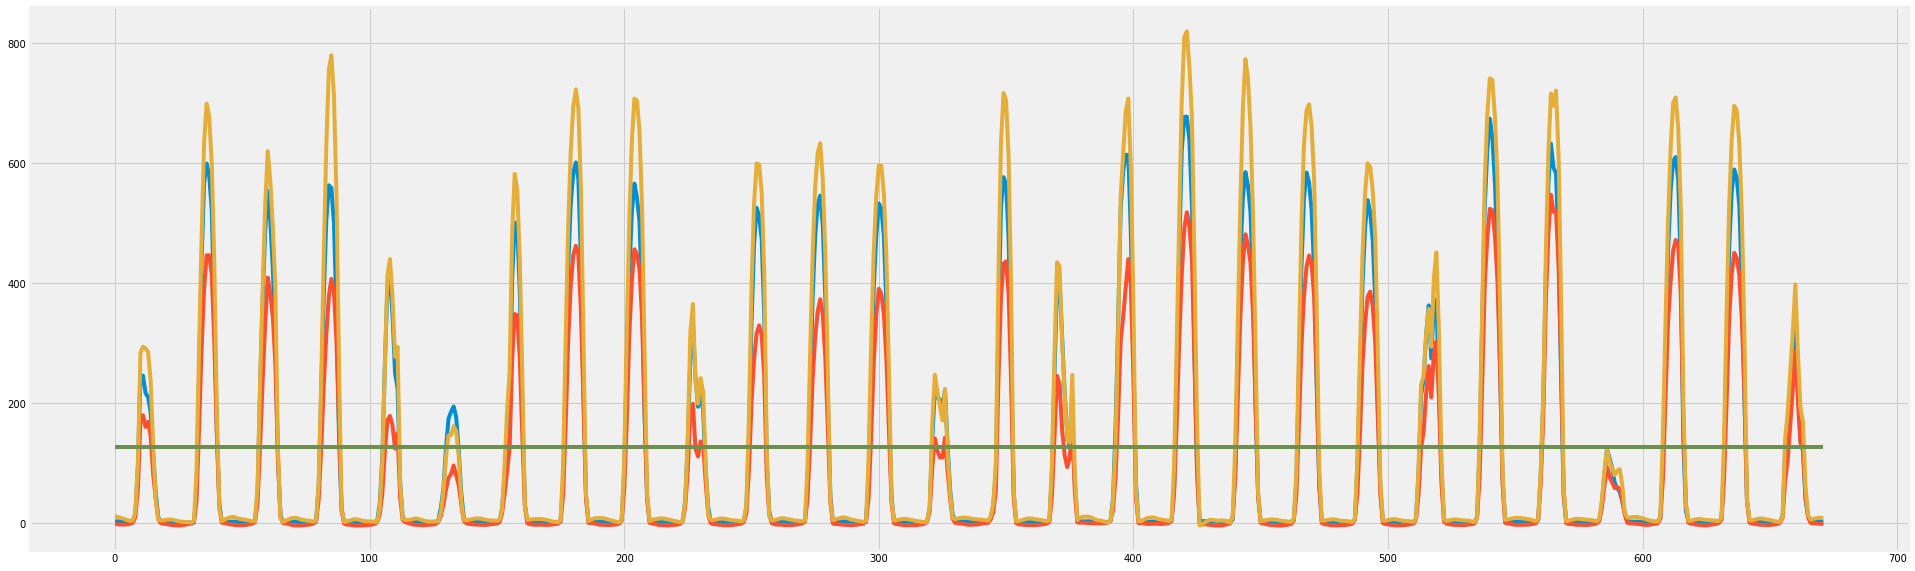

In [ ]:
# notzero
plt.figure(figsize = (30, 10))
plt.plot(sample_submission['dangjin_floating'][:672])
plt.plot(sample_submission['dangjin_warehouse'][:672])
plt.plot(sample_submission['dangjin'][:672])
plt.plot(sample_submission['ulsan'][:672])

In [ ]:
sample_submission.to_csv("/content/gdrive/MyDrive/dacon_timeseries/final_model/0608_cnn_5fold.csv", index = False)